# Please complete the missing parts in the code below. Moreover, please correct the mistakes in the code if the performance is not satisfactory.

# Implementation of Neural Style Transfer with PyTorch

A method for Neural Style Transfer was described by Leon Gatys et al. (2015) and its implementation using pytorch has been detailed [here.](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html) In the original paper, Gatys et al. presented an artificial neural system that achieves a separation of image content from style, thus allowing to recast the content of one image in the style of any other image. In particular, they derive the neural representations for the content and style of an image from the feature responses of highperforming Deep Neural Networks trained on object recognition.

Reference

Gatys, L. A.; Ecker, A. S. & Bethge, M. (2015), 'A Neural Algorithm of Artistic Style.', https://arxiv.org/abs/1508.06576

In [221]:
# importing libraries to implement style-transfer

from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [222]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [223]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [224]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

# scale imported image transform it into a torch tensor.
# use transforms.Compose to compose multiple transforms together
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])  # transform original images with values in the 
    # range 0 to 255 into torch tensors with values in the range 0 to 1.


# the function to load the image and apply transform. Return the image as a float.
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions (2D CNN
    # requires batch data(4D Tensor of nSamples x nChannels x Height x Width))
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


# load style and content images
style_img = image_loader("drive/My Drive/Style_Image.jpg")
content_img = image_loader("drive/My Drive/Content_Image.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

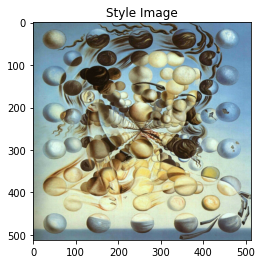

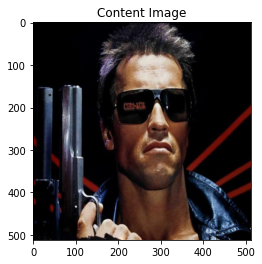

In [225]:
# visualizing the content and style images
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [226]:
# The content loss is a function that represents a weighted version of the 
# content distance for an individual layer. The function takes the feature maps 
# FXL​ of a layer L in a network processing input X and returns the weighted 
# content distance between the image X and the content image C.
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    # Compute the content distance (the mean square error) between feature maps 
    # of the input image X and feature maps of the content image C
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [227]:
# a Gram matrix is the result of multiplying a given matrix by its transposed matrix.
# In this application the given matrix is a reshaped version of the feature maps 
# FXL​ of a layer L in a network processing input X
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [228]:
# computing the style distance using the mean square error between the gram matrix 
# of the input image and gram matrix of the style image
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [229]:
# importing vgg19 pre-trained model. According to Leon Gatys et al., we only need
# features (16 convolutional and 5 pooling layers). We do not use fully connected 
# layers, hence we use the features module of vgg19 model.
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# print model layers. We can verify that CNN is a Sequential model
print(cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [230]:
# according to the original paper (Gatys et al.), replacing the max-pooling
# operation with the average pooling improves the gradient flow and leads to more
# appealing results. Therefore, we replace the max-pooling with the average pooling
for name, child in cnn.named_children():
    if isinstance(child, nn.MaxPool2d):
        cnn[int(name)] = nn.AvgPool2d(kernel_size=2, stride=2)

# print updated model layers.
print(cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (19): Conv2d(256

In [231]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
        
    def forward(self, img):
        # normalize img
        norm_img = (img - self.mean) / self.std
        return norm_img

In [232]:
# desired depth layers to compute style/content losses
# for content layer we have to select one of the higher layers (conv_4 or conv_5)
content_layers_default = ['conv_5']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d) or isinstance(layer, nn.AvgPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

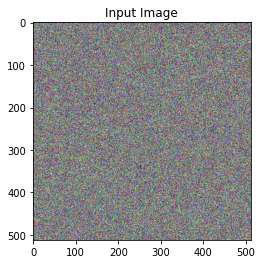

In [233]:
# input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [234]:
def get_input_optimizer(input_img):
    # by uncommenting the following line, we can run the Adam optimizer with 
    # the standard hyperparameters and see that the loss is an order of magnitude 
    # worse in compare with the LBFGS optimizer. 
    # optimizer = optim.Adam(params=[input_img.requires_grad_()], lr=0.01, betas=(0.9, 0.999))
    # As suggested by the author of the algorithm, the L-BFGS optimizer 
    # is the best choice for running gradient descent.
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [235]:
# Debug the code below
# import pdb

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    
    # Since we are training the input image and using the pre-trained CNN model
    # (VGG19), we do not need to optimize the model parameters (compute gradients)
    # and use them in backpropagation.
    input_img.requires_grad_(True)
    model.requires_grad_(False)
    
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            # avoid calculating gradients
            with torch.no_grad():
                input_img.clamp_(0, 1)

            # set the gradients to zero
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            # pdb.set_trace()
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            # call backpropagation
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

### Show your output image

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 46.174400 Content Loss: 11.743888

run [100]:
Style Loss : 5.581686 Content Loss: 8.963419

run [150]:
Style Loss : 2.329482 Content Loss: 7.042703

run [200]:
Style Loss : 1.306146 Content Loss: 5.995780

run [250]:
Style Loss : 0.819252 Content Loss: 5.381251

run [300]:
Style Loss : 0.561318 Content Loss: 4.924963



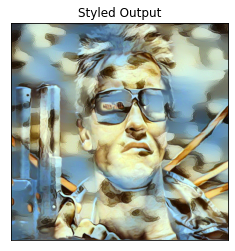

In [236]:
styled_output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
plt.xticks([])
plt.yticks([])
imshow(styled_output, title='Styled Output')

plt.show()

In [237]:
# save styled image
from torchvision.utils import save_image 
save_image(styled_output, "drive/My Drive/arni_styled.jpg")